In one of my job interviews for data scientist position, I encountered a home assignment I'd like to share.

The interviewer sent me a csv file containing samples of measured quantities $x$ and $y$, where $y$ is a response variable which can be written as an explicit function of $x$. It is known that the technique used for measuring $x$ is twice as better than that for measuring $y$ in the sense of standard deviation.

The task: model $y$ as a function of $x$.

Here are all the imports I'll need:

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.stats import probplot

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('data.csv', names=['x', 'y'])
data.head()

,x,y
0,12.209516,36.021575
1,62.623142,162.746072
2,-14.712353,166.459738
3,130.624579,551.308062
4,121.652246,208.207596


Let's visualize the data, to see if it's easy to capture the pattern by eye:

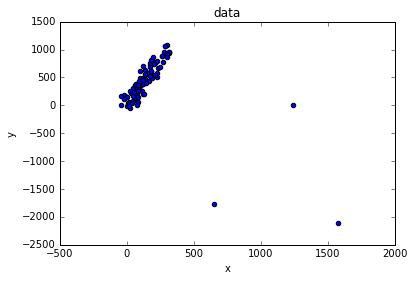

In [3]:
data.plot.scatter('x', 'y', title='data')

It clearly looks like linear regression case. First I'll manually remove the outliers:

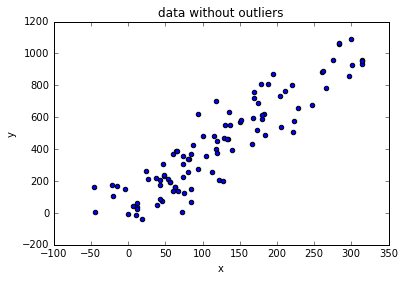

In [4]:
data = data[data['x'] < 600]
data.plot.scatter('x', 'y', title='data without outliers')

I'll use `LinearRegression` to fit the best line:

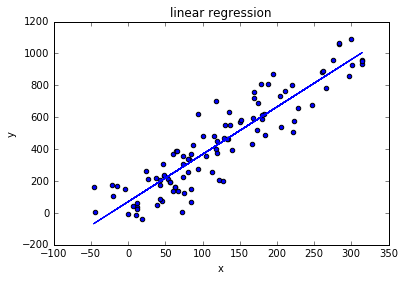

In [5]:
lr = LinearRegression().fit(data[['x']], data['y'])
data.plot.scatter('x', 'y', title='linear regression')
lr_predicted_y = lr.predict(data[['x']])
plt.plot(data['x'], lr_predicted_y)

Visually it looks compelling, but I'll validate linear regression assumptions to be assured I'm using the right model.

If you're not familiar with the linear regression assumptions, you can read about it in the article [Going Deeper into Regression Analysis with Assumptions, Plots & Solutions](https://www.analyticsvidhya.com/blog/2016/07/deeper-regression-analysis-assumptions-plots-solutions/).

Let's plot the residual errors:

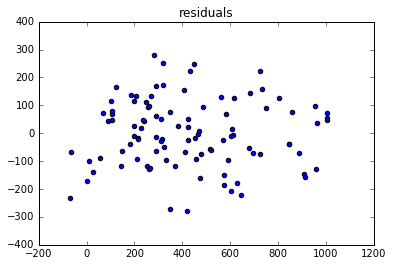

In [6]:
residuals = lr_predicted_y - data['y']
plt.scatter(x=lr_predicted_y, y=residuals)
plt.title('residuals')

* It seems like there's no autocorrelation in the residuals.

* Heteroskedasticity also doesn't look to be a problem here, since the variance pretty much looks constant (except for the left part of the plot, but there's not a lot of data, so I'll ignore that).

* Multicollinearity is not relevant here, since there's only one dependant variable.
* Residuals should be normally distributed: I'll verify that using QQ-plot:

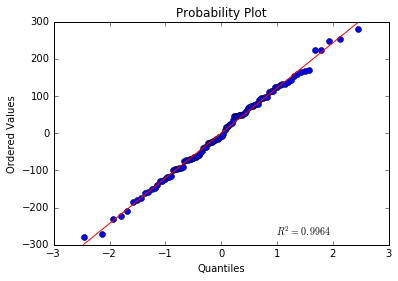

In [7]:
_ = probplot(residuals, plot=plt)

It looks reasonably normal...

I'll conclude that the relationship between $x$ and $y$ assuming linear relationship is best modeled as

In [8]:
print 'y = %f + %f*x'  % (lr.intercept_, lr.coef_)

y = 70.023655 + 2.973585*x


---

We got a consistent estimator of the parameters required for calculating $y$ given $x$ (where both have measurement errors), or in other words, the line's coefficients.

Up until now all I've done is plain old linear regression. The interesting thing about this task is that $x$ has measurement error (which is typical in real world use cases).

If we want to estimate the parameters required for calculating $y$ given the exact $x$ value (without measurement error), we need to use a different approach. Using simple linear regression without accounting for $x$ being random with noise results in line slope slightly smaller than the *true* line slope (the line describing $x$ without measurement errors). You can read [this wiki page](https://en.wikipedia.org/wiki/Errors-in-variables_models#Motivational_example) for learning why. 

I'll use [Deming regression](https://en.wikipedia.org/wiki/Deming_regression), which is a method that can be used when the errors for the two variables $x$ and $y$ are assumed to be independent and normally distributed, and the ratio of their variances, denoted $\delta$, is known. This approach is a perfect fit for our settings, where we have
> The technique used for measuring $x$ is twice as better than that for measuring $y$ in the sense of standard deviation.

So in our settings, $\delta$ is 2 squared.

Using the formulas found in the [wiki page](https://en.wikipedia.org/wiki/Deming_regression#Solution), we get

In [9]:
cov = data.cov()
mean_x = data['x'].mean()
mean_y = data['y'].mean()
s_xx = cov['x']['x']
s_yy = cov['y']['y']
s_xy = cov['x']['y']
delta = 2 ** 2

slope = (s_yy  - delta * s_xx + np.sqrt((s_yy - delta * s_xx) ** 2 + 4 * delta * s_xy ** 2)) / (2 * s_xy)
intercept = mean_y - slope  * mean_x

Using Deming regression, the relationship between $x$ and $y$ is modeled as

In [10]:
print 'y = %f + %f*x'  % (intercept, slope)

y = 19.575797 + 3.391855*x


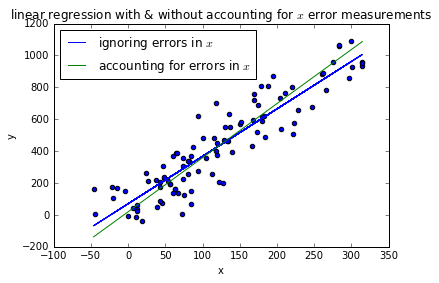

In [11]:
data.plot.scatter('x', 'y', title='linear regression with & without accounting for $x$ error measurements')
plt.plot(data['x'], lr_predicted_y, label='ignoring errors in $x$')
X = [data['x'].min(), data['x'].max()]
plt.plot(X, map(lambda x: intercept + slope * x, X), label='accounting for errors in $x$')
plt.legend(loc='best')

---

We fit two models: one is a simple linear regression model, and the other is a linear regression model accounting for the $x$ measurement errors.

The more simple one may be enough if our purpose is to calculate $y$ given a new $x$ where the new $x$ also has measurement error (resulting from the same distribution as the measurement errors used when training the model).

If we want to state the true relationship for $y$ as a function of $x$ in a world without measurement errors, we should go with the second model.

---

This was a great interview question, since I got to learn a new kind of model, which is pretty nice :)

Although this isn't really an example for *linear regression in the wild* as the title suggests (ok, I lied), this post does demonstrate an important concept many people don't deal with: the dependant variables in many cases are measured in an inaccurate way, which might need to be accounted for (depending on the application).

Regress with care!